In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-cub-dataset/CUB_200_2011.tgz


In [32]:
!tar -xvzf /kaggle/input/cnn-cub-dataset/CUB_200_2011.tgz

attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

In [34]:
checkpoint_dir = '/kaggle/working/model_checkpoints'

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Print the directory path for confirmation
print(f"Checkpoint directory: {checkpoint_dir}")

# List contents of the directory before saving
print("Contents of checkpoint directory before saving:")
print(os.listdir(checkpoint_dir))

Checkpoint directory: /kaggle/working/model_checkpoints
Contents of checkpoint directory before saving:
[]


In [35]:
data=tf.keras.preprocessing.image_dataset_from_directory(
    'CUB_200_2011/images/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 11788 files belonging to 200 classes.


In [36]:
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()

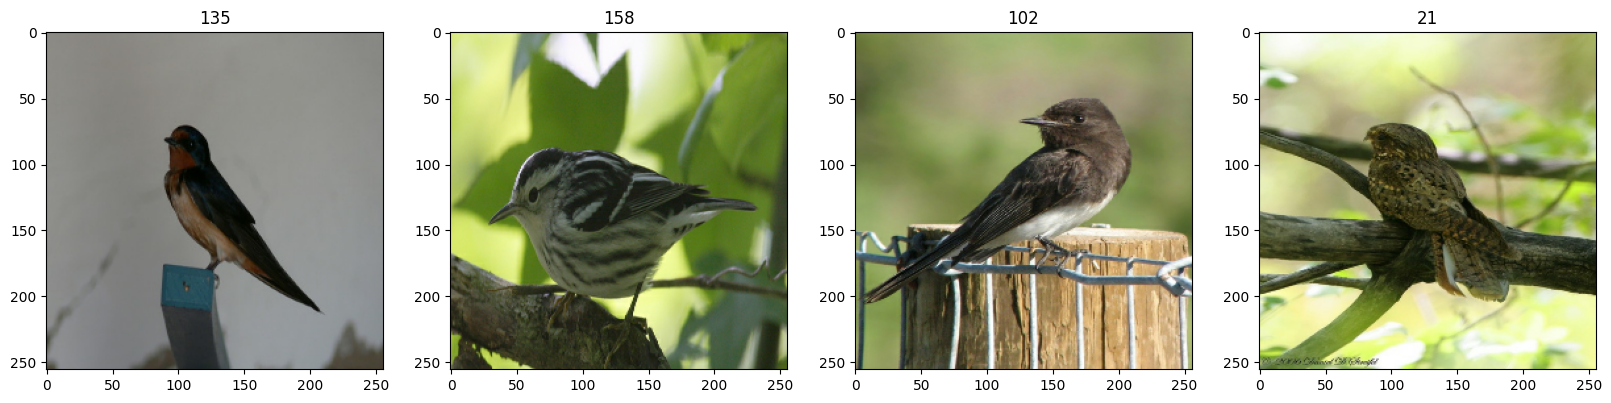

In [37]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [38]:
data=data.map(lambda x, y: (x/255, y))

In [39]:
train_size = 8252
val_size = 1178
test_size = 2358

train_data = data.take(train_size)
test_data = data.take(test_size)
val_data = data.take(val_size)

Epoch 1/40
  6/369 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0000e+00 - loss: 5.5030

W0000 00:00:1721798784.757272     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0063 - loss: 5.3935

W0000 00:00:1721798798.084357     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.0063 - loss: 5.3933 - val_accuracy: 0.0202 - val_loss: 5.2578
Epoch 2/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.0254 - loss: 5.1541 - val_accuracy: 0.0348 - val_loss: 4.9929
Epoch 3/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.0419 - loss: 4.9351 - val_accuracy: 0.0898 - val_loss: 4.6451
Epoch 4/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.0794 - loss: 4.6598 - val_accuracy: 0.1966 - val_loss: 4.1941
Epoch 5/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.1687 - loss: 4.2532 - val_accuracy: 0.2934 - val_loss: 3.7749
Epoch 6/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.2823 - loss: 3.8159 - val_accuracy: 0.4336 - val_loss: 3.3913
Epoch 7/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.4088 - loss: 3.4176 - val_accuracy: 0.5143 - val_loss: 3.1429
Epoch 8/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.5269 - loss: 3.0738 - val_accurac

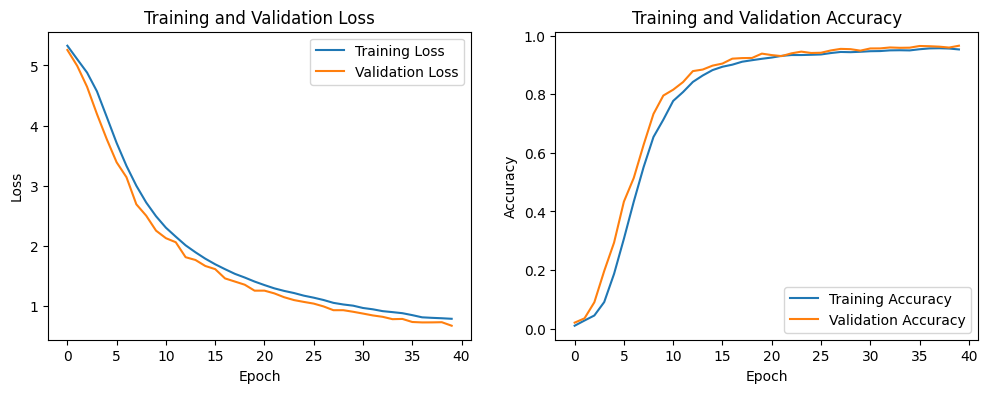

In [40]:
model=Sequential([  
  Conv2D(8, (3,3), 1, activation='relu'),
  BatchNormalization(),
  MaxPooling2D((2,2)),  
  Flatten(),
  Dense(8, activation='relu'),
  BatchNormalization(),  
  Dense(200, activation='softmax', kernel_regularizer=l2(0.01))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras')
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(train_data, epochs=40, validation_data=val_data)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test accuracy:', test_accuracy*100.0,'%')

369/369 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9647 - loss: 0.6941
Test accuracy: 96.58126831054688 %


In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 254, 254, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 129032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │     1,032,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │         1,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,102,994 (11.84 MB)

 Trainable params: 1,034,320 (3.95 MB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 2,068,642 (7.89 MB)

In [ ]:
final_model_path = os.path.join(checkpoint_dir, 'final_model.keras')
model.save(checkpoint_path)
model.save(final_model_path)
print(f'Final model saved to {final_model_path}')